# Build a new transient (*non volumetric rate* ; *host-bias model*)

To build a new transient, you only need 3 things:
- a **rate**: how many targets to draw as a function of redshift. 
- a **template**: what is the spectro-photometric template as a function of phase
- a **model**: what are the transient parameter drawn. This enters [modeldag](https://github.com/MickaelRigault/modeldag).

**Then, simply do that:**
***
```python
from skysurvey.target import Transient
class MyTransient( Transient):
    _KIND = "SN_III" # your transient name
    _TEMPLATE = "a_template" # skysurvey.Template or sncosmo.source (or name)
    _RATE = float # float (Volume Rate in Gyr/year ; or redshift function)
    _MODEL = dict # how are parameter drawn
```
***

## Here is the transient we will do


We will create a new transient, based on the **v19-2004gq-corr** [sncosmo source](https://sncosmo.readthedocs.io/en/stable/source-list.html#list-of-built-in-sources) **template** (a TimeSerie). 

This transient will have a **rate** that increases up-to z=1 and then drops ; we will use a normal distribution. 

The TimeSerie sncosmo sources have 3 parameters, `z`, `amplitude` and `t0`. But, our transient has its absolute magnitude that dependent on his host's mass: these from masses greater than 10^10 solar masses are brighter than those from lower mass hosts.

**Ok, let's go !**

## 1. the template

That is very simple, `skysurvey` accepts any sncosmo source.

In [1]:
my_template = "v19-2004gt-corr"

to be more explicit you could also do (this is what will happen under the hood):

In [2]:
from skysurvey.template import Template
my_template = Template.from_sncosmo("v19-2004gt-corr")

## 2. change the rate

We do not want a simple volumetric rate, but one that depends on redshift.

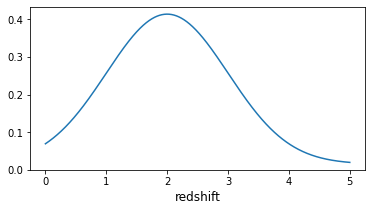

In [26]:
import numpy as np
from scipy import stats
def my_rate(z_, zmax=2, rise=1):
    """ my own rate somewhat connected to Star Formation history """
    c = stats.norm.pdf(z_, loc=zmax, scale=rise)
    return 0.015+c
    
# This is how it looks
import matplotlib.pyplot as plt
fig = plt.figure(figsize=[6,3])
ax = fig.add_subplot(111)

zz = np.linspace(0,5,1_000)
ax.plot(zz, my_rate(zz))
ax.set_xlabel("redshift", fontsize="large");

The `my_rate` function can directly be used as **_RATE** class attribute

### Changing the rate of a TimeSerie

So far, the only thing we do is to change the rate of a TimeSerie Transient, so let's inherite a TSTransient changing its rate, using `my_rate`

In [4]:
import skysurvey
class MyTransient( skysurvey.TSTransient):
    _TEMPLATE = "v19-2004gt-corr" # skysurvey.Template or sncosmo.source (or name)
    _RATE = staticmethod(my_rate) # don't forget the static if given have class attribute

In [5]:
mine = MyTransient.from_draw(size=10_000, zmax=2)

classic = skysurvey.TSTransient.from_draw(size=10_000, zmax=2, 
                                          # For generic transient, specify the source and rate
                                          rate=0.001, source="v19-2004gt-corr")

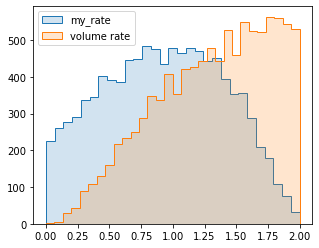

In [27]:
from matplotlib.colors import to_rgba

fig = plt.figure(figsize=[5,4])
ax = fig.add_subplot(111)

prop = dict(histtype="step", fill=True, range=[0,2], bins="auto")
ax.hist(mine.data["z"], facecolor=to_rgba("C0",0.2), edgecolor="C0", label="my_rate", **prop)
ax.hist(classic.data["z"],  facecolor=to_rgba("C1",0.2), edgecolor="C1", label="volume rate", **prop)

ax.legend(loc="best");

### Directly using TSTransient.from_draw()

`TSTransient` is very generic, so as long as you don't want to create a new class of transient to be vastly used, but simply want to see the effect of changing the rate, the model or the template, you can directly do it while calling `TSTransient.from_draw()`. These change will only affect the instance loaded. 

for instance, the above `mine` could have been created as such

In [7]:
mine = skysurvey.TSTransient.from_draw(size=10_000, zmax=2, 
                                          # For generic transient, specify the source and rate
                                          rate=my_rate, source="v19-2004gt-corr")

## 3. change the model


As mentioned, we want a transient which absolute magnitude dependents on his host's mass. So we need to specify the host mass distribution model and how this connect the the absolute luminosity of the transient

### 3.1 the `hostmass`

[modeldag](https://github.com/MickaelRigault/modeldag) model's `func` can either return a list of values matching size (like random.uniform(size=)) or return 2 values, x and pdf(x). The code will then know it is a PDF and draw x, following this PDF to get the sample random distribution

In [8]:
def get_skewednormal(xx="6:13:0.01", mu=11, sigma=2, skewness=-3):
    """ pdf model for the host mass"""
    if type(xx) == str: # assumed r_ input
        xx = eval(f"np.r_[{xx}]")

    pdf = (2/sigma) * stats.norm.pdf(xx, mu, sigma) * stats.norm.cdf(skewness*(xx-mu)/sigma, 0, 1)
    # returns x and pdf(x) for modeldag
    return xx, pdf
    

example:

In [9]:
my_model = {"hostmass": {"func":get_skewednormal,
                        "kwargs":{}}}

In [10]:
import modeldag
dag = modeldag.ModelDAG(my_model)

In [11]:
dag.draw(100).head(5)

,hostmass
0,11.27
1,7.43
2,9.51
3,10.99
4,8.57


### 3.2 An absolute magnitude (`magabs`) that depends on `hostmass`

Say we want the targets to have a norm distribution ob -18±1 mag.

But we want to targets from $hostmass > 10^{10}$ solar masses to be 0.1 mag brighter (so -19±1 mag)

In [12]:
def get_absolute_magnitude(hostmass, mean=-18, scale=1, magoffset=-1, masscut=10):
    """ simple normal distribution with an offset for highmass hosts """
    size = len(hostmass)
    magabs = np.random.normal(size=size, loc=-18, scale=1)
    magabs[hostmass>masscut] += magoffset
    return magabs

To connect the function and parameter (see [modeldag](https://github.com/MickaelRigault/modeldag))

In [13]:
my_model = {"hostmass": {"func":get_skewednormal,
                        "kwargs":{}},
           "magabs": {"func": get_absolute_magnitude,
                      "kwargs":{"hostmass":"@hostmass"}
                     }
           }
dag = modeldag.ModelDAG(my_model)
dag.draw(100).head(5)

,hostmass,magabs
0,6.30,-17.478876
1,10.12,-18.296278
2,6.95,-18.516237
3,9.34,-17.528627
4,8.59,-18.331026


### 3.3 draw `t0`,  `z`

let's use simple uniform distribution for `t0` and the rate for `z`.

In [14]:
my_model = {"hostmass": {"func":get_skewednormal,
                        "kwargs":{}},
           "magabs": {"func": get_absolute_magnitude,
                      "kwargs":{"hostmass":"@hostmass"}
                     },
           "t0": {"func": np.random.uniform,
                 "kwargs": {"low":56_000, "high":56_100}
                 },
            "redshift": {"as":"z"}, # use redshift with know other info to use rate
           }


### 3.4 the transient coordinates `ra`,`dec` (requested for matching the transient with a survey)

In [15]:
from skysurvey.tools import random_radec

In [16]:
my_model = {"hostmass": {"func":get_skewednormal,
                        "kwargs":{}},
           "magabs": {"func": get_absolute_magnitude,
                      "kwargs":{"hostmass":"@hostmass"}
                     },
           "t0": {"func": np.random.uniform,
                 "kwargs": {"low":56_000, "high":56_100}
                 },
            "redshift": {"as":"z"}, # use redshift with know other info to use rate
            "radec": {"func":random_radec,
                     "as":["ra","dec"]} # random_radec returns a list, here are the names
           }

### 3.4 derive `magobs` and `amplitude`

The conversion methods between absolute magnitude to observed magnitude to model amplitude are part of the core Transient methods

In [17]:
my_model = {"hostmass": {"func":get_skewednormal,
                        "kwargs":{}},
           "magabs": {"func": get_absolute_magnitude,
                      "kwargs":{"hostmass":"@hostmass"}
                     },
           "t0": {"func": np.random.uniform,
                 "kwargs": {"low":56_000, "high":56_100}
                 },
            "redshift": {"as":"z", "kwargs":{"zmax":0.2}}, # use redshift with know other info to use rate
            "radec": {"func":random_radec,
                     "as":["ra","dec"]  # random_radec returns a list, here are the names
                     },
        
            "magobs": {"func": "magabs_to_magobs", # in string, means method of Transient
                        "kwargs":{"z": "@z", "magabs": "@magabs"}, # name of the input, after 'as'
                     },
            "amplitude": {"func":"magobs_to_amplitude",# in string, means method of Transient
                          "kwargs":{"magobs":"@magobs"},
                        }
           }

## `MyTransient`

In [18]:
from skysurvey.target import Transient
class MyTransient( Transient):
    _KIND = "my_own_transient" 
    _TEMPLATE = my_template
    _RATE = staticmethod(my_rate)
    _MODEL = my_model


In [19]:
my_transient = MyTransient()

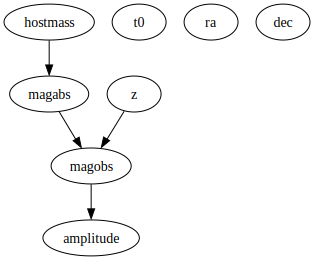

In [20]:
my_transient.model.visualize()

In [21]:
_ = my_transient.draw(1_000)

If now you are checking the variations

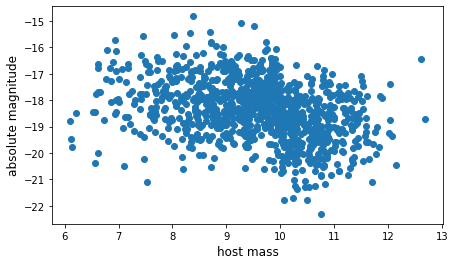

In [25]:
fig = my_transient.show_scatter("hostmass", "magabs")
ax= fig.axes[0]

ax.set_xlabel("host mass", fontsize="large")
ax.set_ylabel("absolute magnitude", fontsize="large");
